<a href="https://colab.research.google.com/github/MargaretZhou/MISA-Bootcamp-2021/blob/main/ClassificationMZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D , MaxPooling2D, BatchNormalization , Flatten , Dropout, Add
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam # - Works
from tensorflow.keras.applications import resnet50, densenet
from tensorflow.keras import regularizers

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,f1_score, precision_score, recall_score, roc_auc_score

import tensorflow as tf

import cv2
import os

import numpy as np
import pandas as pd

# Connect to Google Drive to access data

Note sure how else to access data besides using Google Drive. But you can upload data into drive, mount drive and access data from drive.

Already created a data folder called 432DeepLearning_SantaData. Link here:
https://drive.google.com/drive/u/0/folders/1N0cZ-UM4h124fx6l4SRpmOcKkfGlnmuA

In [3]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Mounted at /content/drive


# Load Data

https://www.analyticsvidhya.com/blog/2020/10/create-image-classification-model-python-keras/

In [4]:
labels=['santa', 'not-a-santa']
img_size = 224

def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

train_dir = './drive/MyDrive/432DeepLearning_SantaData/is_that_santa/train' # train image folder
test_dir = './drive/MyDrive/432DeepLearning_SantaData/is_that_santa/test' # test image folder

train = get_data(train_dir)
test = get_data(test_dir)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


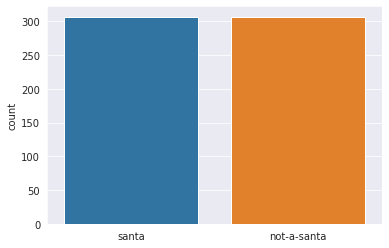

In [ ]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("santa")
    else:
        l.append("not-a-santa")
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'santa')

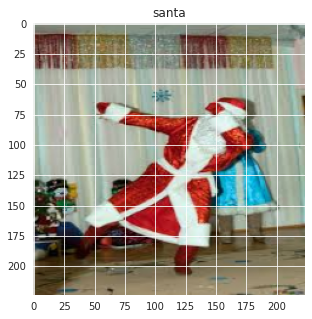

In [ ]:
# santa sample
plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])

Text(0.5, 1.0, 'not-a-santa')

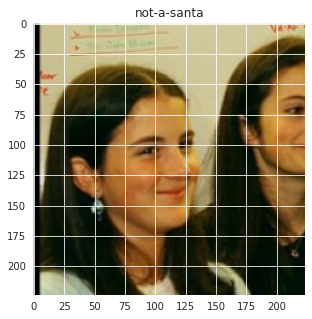

In [ ]:
# nonsanta sample
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

# Data Preprocessing and Data Augmentation

In [6]:
x_train = []
y_train = []
x_test = []
y_test = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in test:
  x_test.append(feature)
  y_test.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [7]:
# Data augmentatio on train data
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

# Modeling

In [15]:
# Define the Model Architecture
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(224,224,3)))
model.add(BatchNormalization())

model.add(MaxPooling2D())
model.add(Dropout(0.4))

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(BatchNormalization())

model.add(MaxPooling2D())
model.add(Dropout(0.4))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.L1(0.0001)))
model.add(BatchNormalization())

model.add(MaxPooling2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_6 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 112, 112, 32)      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_7 (Batc  (None, 112, 112, 64)    

In [18]:
# Compile model with Adam optimizer
opt = Adam(learning_rate=0.000001)
model.compile(optimizer = opt , loss = 'binary_crossentropy' , metrics = ['accuracy'])

In [ ]:
# Train
history = model.fit(x_train,y_train,epochs = 150 , validation_data = (x_test, y_test))

Epoch 1/150
20/20 [==============================] - 3s 105ms/step - loss: 0.5148 - accuracy: 0.8713 - val_loss: 0.7362 - val_accuracy: 0.7338
Epoch 2/150
20/20 [==============================] - 2s 96ms/step - loss: 0.5197 - accuracy: 0.8616 - val_loss: 0.7370 - val_accuracy: 0.7354
Epoch 3/150
20/20 [==============================] - 2s 97ms/step - loss: 0.4852 - accuracy: 0.8860 - val_loss: 0.7330 - val_accuracy: 0.7451
Epoch 4/150
20/20 [==============================] - 2s 96ms/step - loss: 0.4817 - accuracy: 0.8876 - val_loss: 0.7244 - val_accuracy: 0.7516
Epoch 5/150
20/20 [==============================] - 2s 97ms/step - loss: 0.4479 - accuracy: 0.9169 - val_loss: 0.7210 - val_accuracy: 0.7581
Epoch 6/150
20/20 [==============================] - 2s 96ms/step - loss: 0.4891 - accuracy: 0.8941 - val_loss: 0.7019 - val_accuracy: 0.7695
Epoch 7/150
20/20 [==============================] - 2s 96ms/step - loss: 0.4745 - accuracy: 0.8860 - val_loss: 0.6975 - val_accuracy: 0.7727
Epoch

# Model Evaluation

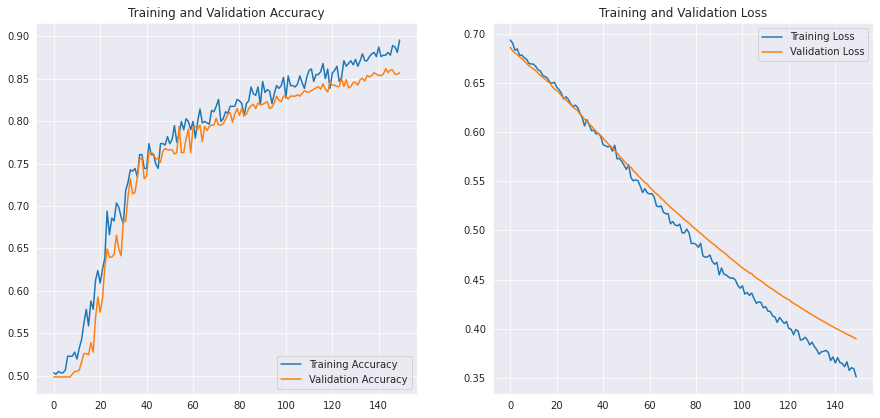

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(150)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#Create a function to remote performance metrics
def report_scores(yhat):
  #accuracy score
  print('Accuracy:', accuracy_score(y_test, yhat))
  
  #precision score
  print('Precision:', precision_score(y_test, yhat, average = 'weighted'))
  
  #recall score
  print('Recall:', recall_score(y_test, yhat, average = 'weighted'))

  #F1 score
  print('F1:', f1_score(y_test, yhat, average = 'weighted'))

  #Classification Report
  print('\n', classification_report(y_test, yhat, target_names = ['Santa (Class 0)','Not-a-santa (Class 1)']))

  #Print confusion matrix:
  confusion_matrix = pd.crosstab(index=y_test, columns=yhat, rownames=['Expected'], colnames = ['Predicted'])
  sns.heatmap(confusion_matrix, annot = True, square = False, fmt = '', cbar = False)
  plt.title("Classification Matrix", fontsize = 15)
  plt.show()



In [ ]:
len(y_test)

616

Accuracy: 0.8571428571428571
Precision: 0.8605636201098295
Recall: 0.8571428571428571
F1: 0.8568032206595588

                        precision    recall  f1-score   support

      Santa (Class 0)       0.83      0.91      0.86       308
Not-a-santa (Class 1)       0.90      0.81      0.85       308

             accuracy                           0.86       616
            macro avg       0.86      0.86      0.86       616
         weighted avg       0.86      0.86      0.86       616



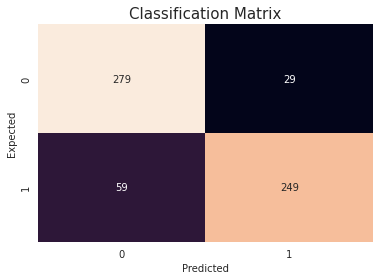

In [ ]:
predict = model.predict(x_test)
classes=np.array([1 if  i > 0.5 else 0 for i in predict])
report_scores(yhat = classes)

# Competitive Models

## ResNet()

https://chroniclesofai.com/transfer-learning-with-keras-resnet-50/

In [ ]:
resnet_model = Sequential()
pretrained = resnet50.ResNet50(weights = "imagenet", include_top = False,
                          input_tensor = Input(shape=(224,224,3)))

for layer in pretrained.layers[:150]:
  layer.trainable=False

resnet_model.add(pretrained)

# Add fully connected and output layer where learning takes place:
resnet_model.add(Flatten())
resnet_model.add(Dense(128, activation='relu'))
resnet_model.add(Dense(1, activation='sigmoid'))

# Model Architect
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               12845184  
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 36,433,025
Trainable params: 22,835,457
Non-trainable params: 13,597,568
_________________________________________________________________


In [ ]:
opt = Adam(lr=0.00001)
resnet_model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])

history2 = resnet_model.fit(x_train,y_train,epochs = 150 , validation_data = (x_test, y_test))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/150
20/20 [==============================] - 11s 333ms/step - loss: 0.4667 - accuracy: 0.7964 - val_loss: 0.6951 - val_accuracy: 0.5000
Epoch 2/150
20/20 [==============================] - 4s 219ms/step - loss: 0.1850 - accuracy: 0.9218 - val_loss: 0.7505 - val_accuracy: 0.5000
Epoch 3/150
20/20 [==============================] - 4s 221ms/step - loss: 0.0889 - accuracy: 0.9772 - val_loss: 0.7754 - val_accuracy: 0.5000
Epoch 4/150
20/20 [==============================] - 4s 222ms/step - loss: 0.0557 - accuracy: 0.9919 - val_loss: 0.8544 - val_accuracy: 0.5000
Epoch 5/150
20/20 [==============================] - 4s 222ms/step - loss: 0.0534 - accuracy: 0.9886 - val_loss: 0.9060 - val_accuracy: 0.5000
Epoch 6/150
20/20 [==============================] - 4s 224ms/step - loss: 0.0878 - accuracy: 0.9691 - val_loss: 0.9763 - val_accuracy: 0.5000
Epoch 7/150
20/20 [==============================] - 4s 223ms/step - loss: 0.0460 - accuracy: 0.9886 - val_loss: 0.8125 - val_accuracy: 0.508

### Model Evaluation

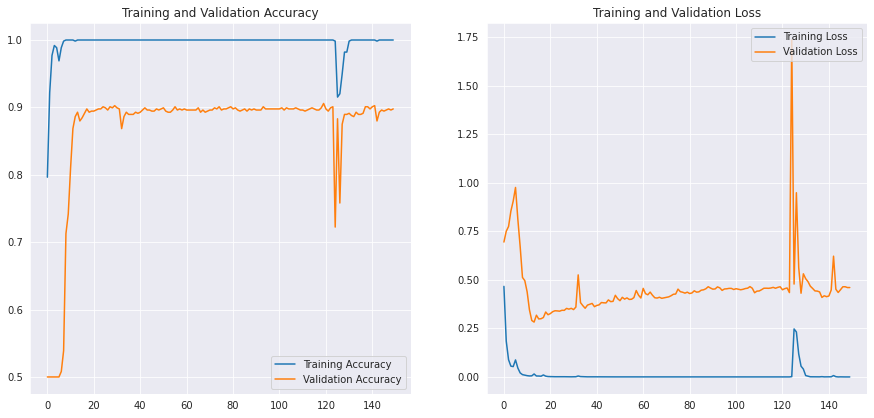

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(150)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Accuracy: 0.8977272727272727
Precision: 0.9003650293402944
Recall: 0.8977272727272727
F1: 0.8975585419355862

                        precision    recall  f1-score   support

      Santa (Class 0)       0.87      0.94      0.90       308
Not-a-santa (Class 1)       0.93      0.86      0.89       308

             accuracy                           0.90       616
            macro avg       0.90      0.90      0.90       616
         weighted avg       0.90      0.90      0.90       616



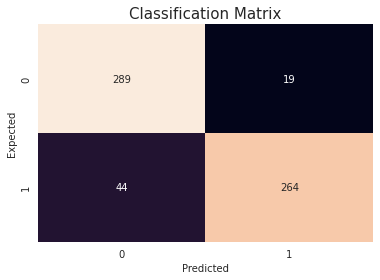

In [ ]:
predict = resnet_model.predict(x_test)
classes=np.array([1 if  i > 0.5 else 0 for i in predict])
report_scores(yhat = classes)

## DenseNet

In [ ]:
densenet_model = Sequential()
pretrained = densenet.DenseNet121(weights = "imagenet", include_top = False,
                          input_tensor = Input(shape=(224,224,3)))

for layer in pretrained.layers[:150]:
  layer.trainable=False

densenet_model.add(pretrained)

# Add fully connected and output layer where learning takes place:
densenet_model.add(Flatten())
densenet_model.add(Dense(128, activation='relu'))
densenet_model.add(Dense(1, activation='sigmoid'))
#densenet_model.add(Flatten())

# Model Architect
densenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten_2 (Flatten)         (None, 50176)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               6422656   
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 13,460,289
Trainable params: 11,876,033
Non-trainable params: 1,584,256
_________________________________________________________________


In [ ]:
opt = Adam(learning_rate=0.0001)
densenet_model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])

history3 = densenet_model.fit(x_train,y_train,epochs = 150 , validation_data = (x_test, y_test))

Epoch 1/150
20/20 [==============================] - 21s 516ms/step - loss: 0.3352 - accuracy: 0.8697 - val_loss: 0.1768 - val_accuracy: 0.9448
Epoch 2/150
20/20 [==============================] - 5s 272ms/step - loss: 0.0242 - accuracy: 0.9935 - val_loss: 0.2937 - val_accuracy: 0.9318
Epoch 3/150
20/20 [==============================] - 5s 275ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.1840 - val_accuracy: 0.9481
Epoch 4/150
20/20 [==============================] - 5s 276ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.1337 - val_accuracy: 0.9545
Epoch 5/150
20/20 [==============================] - 5s 277ms/step - loss: 0.0100 - accuracy: 0.9951 - val_loss: 0.4172 - val_accuracy: 0.9156
Epoch 6/150
20/20 [==============================] - 5s 276ms/step - loss: 0.0182 - accuracy: 0.9902 - val_loss: 0.0592 - val_accuracy: 0.9870
Epoch 7/150
20/20 [==============================] - 5s 273ms/step - loss: 2.7534e-04 - accuracy: 1.0000 - val_loss: 0.1224 - val_accuracy: 0

### Model Evaluation

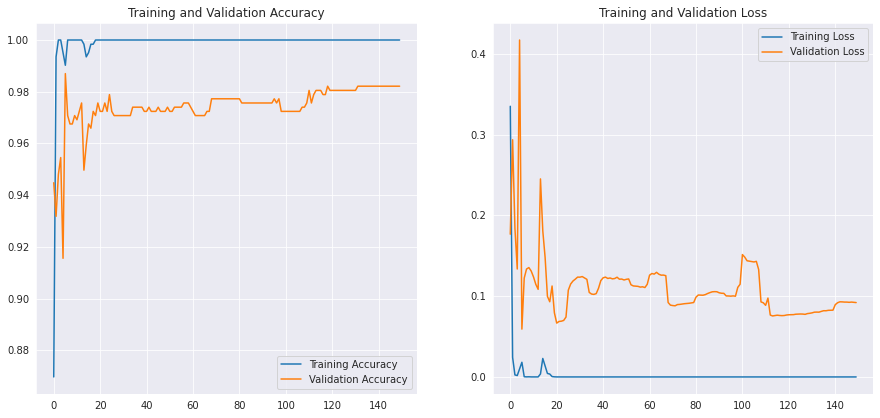

In [ ]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(150)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Accuracy: 0.9821428571428571
Precision: 0.9825548885348638
Recall: 0.9821428571428571
F1: 0.9821390444810543

                        precision    recall  f1-score   support

      Santa (Class 0)       0.97      1.00      0.98       308
Not-a-santa (Class 1)       1.00      0.97      0.98       308

             accuracy                           0.98       616
            macro avg       0.98      0.98      0.98       616
         weighted avg       0.98      0.98      0.98       616



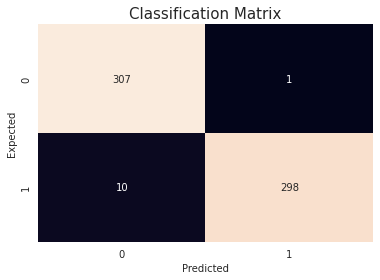

In [ ]:
predict = densenet_model.predict(x_test)
classes=np.array([1 if  i > 0.5 else 0 for i in predict])
report_scores(yhat = classes)